In [1]:
import os
import numpy as np
import pandas as pd
import re
import nltk

# from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import sequence
from sklearn import metrics

from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
# import train/val/test data from the data exploration part

data_prep=np.load('data_prep.npz',allow_pickle=True)
train_text,train_label=data_prep['train_text'],data_prep['train_label']
val_text,val_label=data_prep['val_text'],data_prep['val_label']
test_text,test_label=data_prep['test_text'],data_prep['test_label']
voca_set=data_prep['voca_set'].tolist()

# define encoder and tokenizer
tokenizer=tfds.deprecated.text.Tokenizer()
encoder=tfds.deprecated.text.TokenTextEncoder(
    voca_set,tokenizer=tokenizer)

# 1. BiLSTM model

In [3]:
def LSTM_model(voca_size,embedding_dim,rnn_units,batch_size):
    model=tf.keras.Sequential([
        tf.keras.layers.Embedding(voca_size,embedding_dim,
                                  mask_zero=True,
                                  batch_input_shape=[batch_size,None]),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(rnn_units,dropout=0.25)),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    return model


In [4]:
# length of vocas in chars
voca_size=encoder.vocab_size

embedding_dim=64 

# number of RNN units
rnn_units=64

# batch size
batch_size=100

model=LSTM_model(
    voca_size=voca_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=batch_size)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (100, None, 64)           7094784   
                                                                 
 bidirectional (Bidirectiona  (100, 128)               66048     
 l)                                                              
                                                                 
 dense (Dense)               (100, 1)                  129       
                                                                 
Total params: 7,160,961
Trainable params: 7,160,961
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall'])

mc=ModelCheckpoint(
    'model_param/BiLSTM.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

num_epochs=8

history=model.fit(train_text,train_label,
                  epochs=num_epochs,batch_size=batch_size,
                  callbacks=[mc],
                  validation_data=(val_text,val_label))


Epoch 1/8
698/700 [============================>.] - ETA: 0s - loss: 0.3194 - accuracy: 0.8733 - precision: 0.9142 - recall: 0.7612
Epoch 00001: val_loss improved from inf to 0.21975, saving model to model_param\BiLSTM.h5
700/700 [==============================] - 279s 393ms/step - loss: 0.3191 - accuracy: 0.8734 - precision: 0.9144 - recall: 0.7614 - val_loss: 0.2197 - val_accuracy: 0.9255 - val_precision: 0.9678 - val_recall: 0.8499
Epoch 2/8
699/700 [============================>.] - ETA: 0s - loss: 0.1713 - accuracy: 0.9404 - precision: 0.9672 - recall: 0.8841
Epoch 00002: val_loss improved from 0.21975 to 0.20229, saving model to model_param\BiLSTM.h5
700/700 [==============================] - 629s 900ms/step - loss: 0.1712 - accuracy: 0.9405 - precision: 0.9673 - recall: 0.8842 - val_loss: 0.2023 - val_accuracy: 0.9338 - val_precision: 0.9654 - val_recall: 0.8728
Epoch 3/8
700/700 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9586 - precision: 0.9705 - r

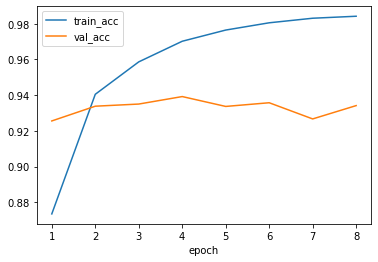

In [6]:
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['accuracy'],label='train_acc')
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['val_accuracy'],label='val_acc')
plt.xlabel('epoch')
plt.legend()
plt.show()

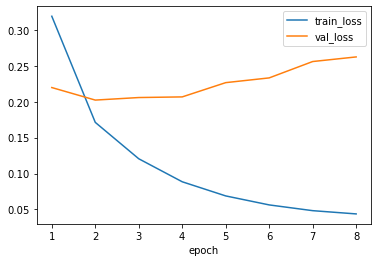

In [7]:
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['loss'],label='train_loss')
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['val_loss'],label='val_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [12]:
# # save the model weights
# model.save_weights('BiLSTM')

# 2. Predictions and Evaluations

In [9]:
# length of vocas in chars
voca_size=encoder.vocab_size

# number of RNN units
rnn_units=64

# batch size
batch_size=100

trained_model=LSTM_model(
    voca_size=voca_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=batch_size)

# load the model weights
trained_model.load_weights('model_param/BiLSTM.h5')


In [10]:
# use the model to make prediction on the test set

test_outputs=trained_model(test_text)
test_pred=((test_outputs.numpy()>0.5)*1).flatten()


In [12]:
test_acc=sum(test_label==test_pred)/len(test_pred)
print('test_acc=',test_acc*100,'%')


test_acc= 93.36666666666666 %
